## MMTHE01 - Masters Thesis

### E2. Thesis - Apply and Evaluate different XAI methods - Case Study with the Isoation Forest Model

* Applying XAI on an Unsupervised Learning AI model (Isolation Forest)
* Applying Model Agnostic Perturbation-based global XAI methods: SP-LIME, NormLIME, Permutation Importance, Adversarial Explanations

#### Importing the libraries

In [1]:
### import general libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

In [2]:
# Check your current working directory
cwd = os.getcwd()

# Define your relative path
relative_path = r"6. Analysis"  # adjust this relative to cwd

# Build the full path
full_path = os.path.join(cwd, relative_path)

# Check if it exists before changing
if os.path.exists(full_path):
    os.chdir(full_path)
    print("Changed directory to:", full_path)
else:
    print("Folder does not exist:", full_path)

Changed directory to: C:\Users\eaber\Documents\11. Masters Thesis Final\6. Analysis


#### Importing the dataset

In [3]:
dataset = pd.read_csv('train_dataset_final_encoded.csv')

In [4]:
dataset.head()

,isFraud,TransactionDT,TransactionAmt,card1,C3,C9,C12,C13,C14,TransactionID,...,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,M4_M0,M4_M1,M4_M2
0,0,86400,68.5,13926,0.0,1.0,0.0,1.0,1.0,2987000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,86401,29.0,2755,0.0,0.0,0.0,1.0,1.0,2987001,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,86469,59.0,4663,0.0,1.0,0.0,1.0,1.0,2987002,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0,86499,50.0,18132,0.0,1.0,0.0,25.0,1.0,2987003,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0,86506,50.0,4497,0.0,0.0,0.0,1.0,1.0,2987004,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
dataset.shape

(590540, 201)

### 5.1 Split the data into Train-Test

#### 5.1.1 Separate the features and the label

In [6]:
dataset_final = dataset.drop('TransactionID', axis=1)

In [7]:
#X = dataset.iloc[:, 1:].values
#y = dataset.iloc[:,0].values

In [8]:
X = dataset_final.iloc[:, 1:]
y = dataset_final.iloc[:,0]

In [9]:
from sklearn.model_selection import train_test_split
X_train_im, X_test, y_train_im, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 1)

### 5.2 Applying SMOTE

In [10]:
# Applying SMOTE only to the training data
smote = SMOTE(random_state=1)
X_train, y_train = smote.fit_resample(X_train_im, y_train_im)

### 5.3 Feature Scaling

In [11]:
sc = StandardScaler()
X_tn_scaled = sc.fit_transform(X_train)
X_tt_scaled = sc.fit_transform(X_test)


# Convert to dataframe
X_train_scaled = pd.DataFrame(X_tn_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_tt_scaled, columns=X_test.columns)

### 5.4 Model Fitting

In [12]:
from sklearn.ensemble import IsolationForest

In [13]:
# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.035,  # Approximate fraud ratio in dataset
    max_samples='auto',
    random_state=1,
    n_jobs=-1
)

In [14]:
iso_forest.fit(X_train_scaled)

IsolationForest(contamination=0.035, n_jobs=-1, random_state=1)

### 5.5 Applying XAI methods to the Isolation Forest Model

#### 5.5.1 Applying Submodular Pick (SP)-LIME to the Isolation Forest Model
* This is a variant of LIME

In [15]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [16]:
feature_names = X_train.columns.tolist()

In [17]:
sample_size = 100
num_exps_desired = 5

In [18]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout_stderr():
    # Suppress stdout and stderr
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

In [19]:
start_time = time.time()

In [20]:
# Define the prediction function
predict_fn = lambda x: predict_proba_iso(x).astype(float)

In [21]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=feature_names,
    mode='classification',
    class_names=["non-fraud", "fraud"],
    verbose=True
)

In [22]:
# Wrap decision_function into a "pseudo-probability"
def predict_proba_iso(X):
    # Ensure X has feature names if iso_forest was trained with a DataFrame
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=X_train_scaled.columns)  # use training feature names

    scores = iso_forest.decision_function(X)  # higher = more normal

    # Normalize scores into [0, 1] for pseudo-probability
    probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

    # Two-class probabilities: [anomaly, normal]
    return np.vstack([1 - probs, probs]).T

In [23]:
# Initialize the SubmodularPick object
with suppress_stdout_stderr():
    sp_obj = submodular_pick.SubmodularPick(
        lime_explainer,
        X_train_scaled.values,
        predict_fn,
        sample_size=sample_size,
        num_features=10,
        num_exps_desired=num_exps_desired
    )

In [24]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"SP-LIME on Isolation Forest (Explanation Time): {explanation_time:.2f} seconds")

SP-LIME on Isolation Forest (Explanation Time): 138.88 seconds


In [25]:
selected_explanations = sp_obj.explanations[:num_exps_desired]

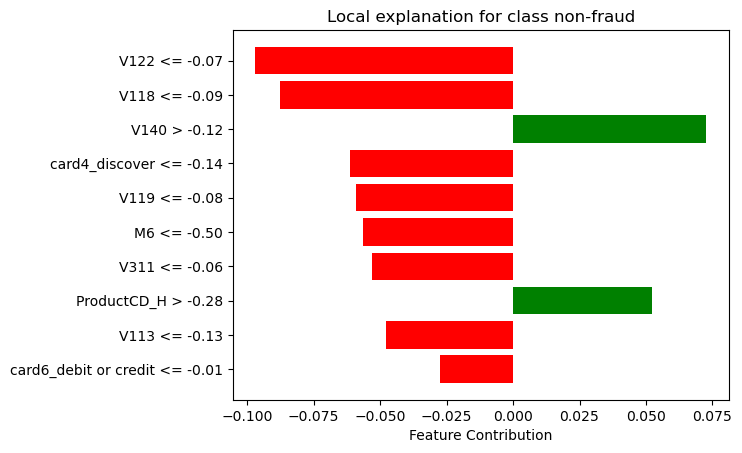

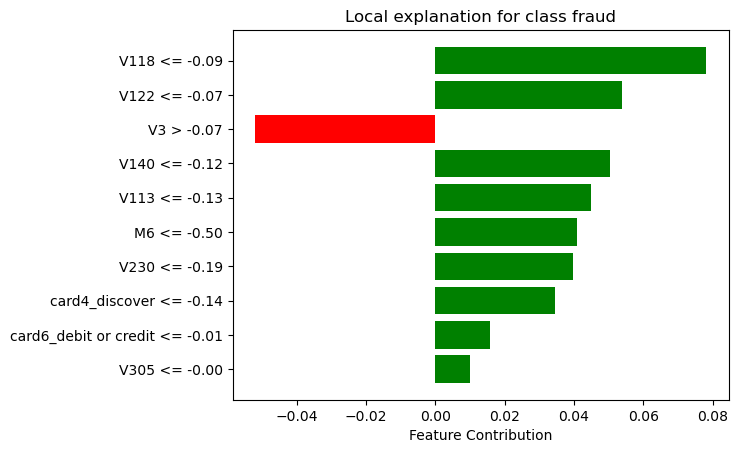

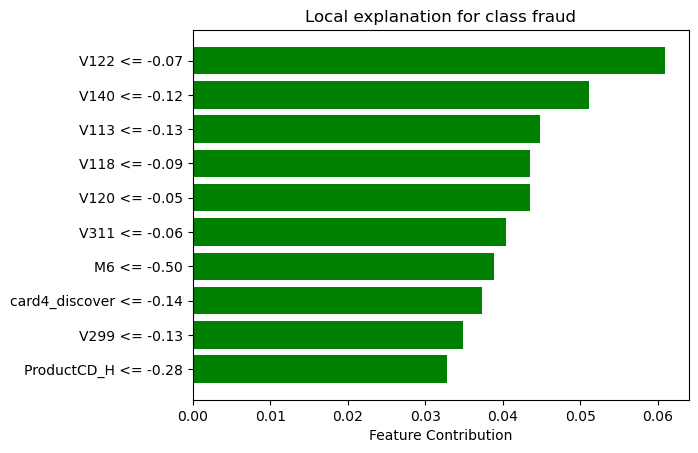

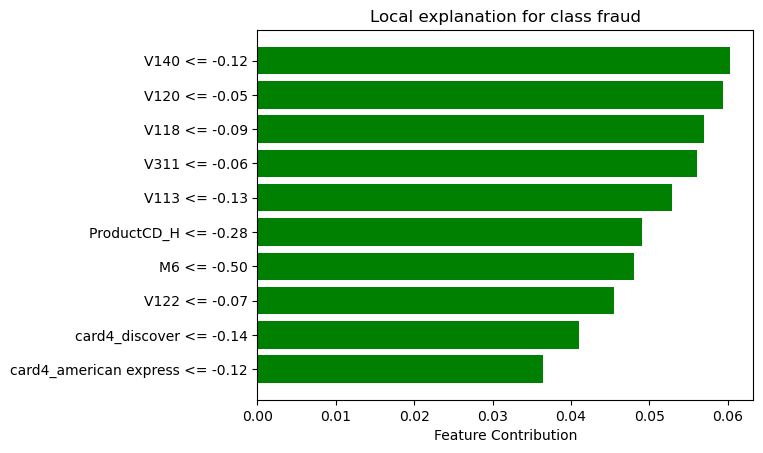

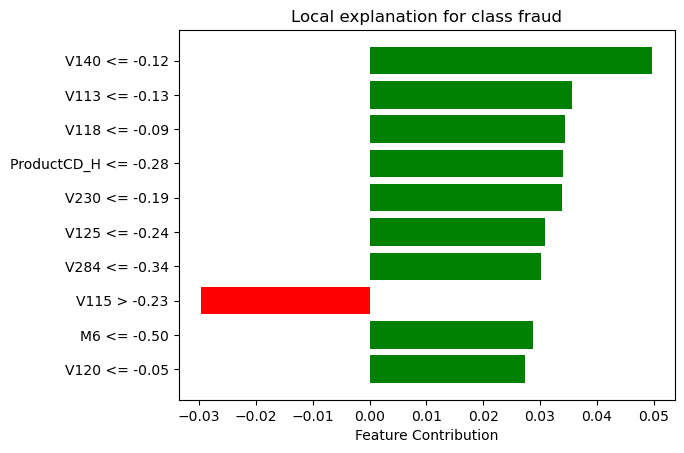

In [26]:
for exp in selected_explanations:
    predicted_class = list(exp.local_exp.keys())[0]
    fig = exp.as_pyplot_figure(label=predicted_class)
    # Label the x-axis
    plt.xlabel("Feature Contribution")
    plt.show()

#### 5.5.2 Applying NormLIME to the Isolation Forest Model
* This is a variant of LIME

In [27]:
from collections import Counter

In [28]:
start_time = time.time()

In [29]:
# Generate explanations for multiple instances. Suppress textual output
with suppress_stdout_stderr():
    explanations = []
    for i in range(100):  # Adjust the number of instances as needed
        explanation = lime_explainer.explain_instance(X_test_scaled.iloc[i].values, predict_proba_iso)
        explanations.append(explanation)

In [30]:
# Aggregate feature importance
feature_importance = Counter()
for explanation in explanations:
    for feature, weight in explanation.as_list():
        feature_importance[feature] += weight

In [31]:
# Normalize the feature importance
total_importance = sum(feature_importance.values())
normalized_importance = {feature: weight / total_importance for feature, weight in feature_importance.items()}

In [32]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"NormLIME on Isolation Forest (Explanation Time): {explanation_time:.2f} seconds")

NormLIME on Isolation Forest (Explanation Time): 53.93 seconds


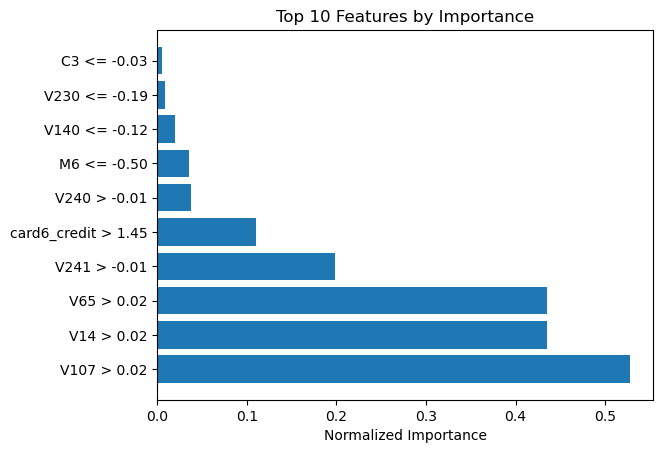

In [33]:
#Visualize the feature importance
# Sort features by importance
sorted_features = sorted(normalized_importance.items(), key=lambda x: x[1], reverse=True)

# Plot the top N features
top_n = 10
features, importances = zip(*sorted_features[:top_n])
plt.barh(features, importances)
plt.xlabel('Normalized Importance')
plt.title('Top {} Features by Importance'.format(top_n))
plt.show()

#### 5.5.3 Applying Permutation Importance to the Isolation Forest Model

In [34]:
from sklearn.inspection import permutation_importance

In [35]:
start_time = time.time()

In [36]:
# Compute permutation importance
result = permutation_importance(
    iso_forest, X_test_scaled, y_test,
    n_repeats=10, random_state=42, scoring='roc_auc'
)

In [37]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"Permutation Important on Isolation Forest (Explanation Time): {explanation_time:.2f} seconds")

Permutation Important on Isolation Forest (Explanation Time): 2137.60 seconds


In [38]:
# Store results in DataFrame
pi_df = pd.DataFrame({
    'feature': X_test_scaled.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

In [39]:
print(pi_df.head(15))

         feature  importance_mean  importance_std
16            M6         0.004009        0.000484
54           V30         0.003637        0.000251
33           D10         0.002729        0.000270
71           V70         0.001661        0.000158
24         id_17         0.001448        0.000112
185  ProductCD_R         0.001293        0.000256
29            D1         0.001263        0.000169
41            V7         0.000899        0.000124
129         V210         0.000839        0.000107
6            C13         0.000790        0.000124
173         V304         0.000788        0.000075
38            V3         0.000724        0.000287
7            C14         0.000720        0.000145
56           V36         0.000692        0.000078
100         V124         0.000685        0.000218


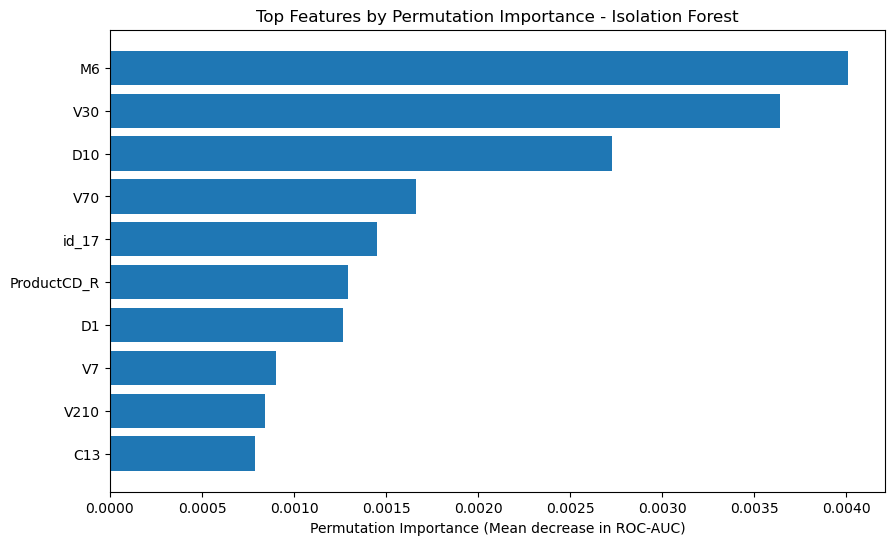

In [40]:
# Plot top 15 features
top_n = 10
plt.figure(figsize=(10,6))
plt.barh(pi_df['feature'].head(top_n)[::-1], pi_df['importance_mean'].head(top_n)[::-1])
plt.xlabel("Permutation Importance (Mean decrease in ROC-AUC)")
plt.title("Top Features by Permutation Importance - Isolation Forest")
plt.show()

#### 5.5.4 Applying Adversarial Explanations to the Isolation Forest Model

In [41]:
from scipy.optimize import differential_evolution

In [42]:
# Define adversarial explanation function 
def adversarial_explanation(model,
    x_orig,                      # 1D numpy array (already preprocessed to model input space)
    target_label=None,          # desired target label (0 or 1). If None -> flip original label.
    feature_bounds=None,        # list of (min, max) for each feature (in same scaled space as x_orig)
    maxiter=200,                # DE iterations
    popsize=15,                 # DE population size multiplier
    penalty_coef=50.0,          # strength of constraint penalty
    norm='l2',                  # 'l2' or 'linf'
    random_state=0
):
    """
    Find a minimal perturbation delta such that predict_proba_iso(x_orig + delta) yields target_label.
    Uses differential_evolution (global, gradient-free).
    Returns: dict { 'delta', 'x_adv', 'orig_prob', 'adv_prob', 'success', 'distance' }
    """
    rng = np.random.RandomState(random_state)
    x_orig = np.asarray(x_orig).astype(float).ravel()
    n = x_orig.size

    # current predicted label and probability
    prob_orig = predict_proba_iso(x_orig.reshape(1, -1))[0,1]
    label_orig = int(prob_orig >= 0.5)
    if target_label is None:
        target = 1 - label_orig
    else:
        target = int(target_label)

    # bounds for delta: by default allow changes within (min_feature - val, max_feature - val)
    if feature_bounds is None:
        # set bounds from training feature ranges (we'll use training min/max scaled)
        # Compute safe bounds around x_orig: +/- 3 STD (in scaled space that's reasonable)
        # but to be general, allow range [-clip, +clip] where clip = max(abs(min,max)) * 1.1
        # Here we set per-feature bounds to ensure we stay inside plausible values.
        fb = []
        X_all = np.vstack([X_train_scaled.values, X_test_scaled.values])
        min_col = X_all[:, :].min(axis=0)
        max_col = X_all[:, :].max(axis=0)
        for i in range(n):
            # bounds for delta so that x_adv remains in [min_col[i], max_col[i]]
            lo = min_col[i] - x_orig[i]
            hi = max_col[i] - x_orig[i]
            fb.append((lo, hi))
    else:
        # feature_bounds given as list of (min,max) for each feature in input space
        fb = []
        for i, (mn, mx) in enumerate(feature_bounds):
            fb.append((mn - x_orig[i], mx - x_orig[i]))

    # objective: minimize norm(delta) + penalty * max(0, threshold - prob_target)
    def objective(delta_flat):
        delta = np.array(delta_flat)
        x_candidate = x_orig + delta
        # clip to bounds (avoid invalid values)
        # compute predicted probability of target class
        proba = predict_proba_iso(x_candidate.reshape(1, -1))[0, 1]
        # fitness for target: we want proba_target >= 0.5 if target==1; else <=0.5
        if target == 1:
            violation = max(0.0, 0.5 - proba)
        else:
            violation = max(0.0, proba - 0.5)
        # distance measure
        if norm == 'l2':
            dist = np.linalg.norm(delta)
        elif norm == 'linf':
            dist = np.max(np.abs(delta))
        else:
            dist = np.linalg.norm(delta)
        # objective: distance + penalty * violation
        return dist + penalty_coef * violation

    # differential evolution
    result = differential_evolution(
        objective,
        fb,
        maxiter=maxiter,
        popsize=popsize,
        tol=1e-5,
        polish=True,
        updating='deferred',
        seed=random_state,
        mutation=(0.5, 1.0),
        recombination=0.7,
    )

    delta_opt = result.x
    x_adv = x_orig + delta_opt
    prob_adv = predict_proba_iso(x_adv.reshape(1, -1))[0,1]
    success = (prob_adv >= 0.5 and target == 1) or (prob_adv < 0.5 and target == 0)
    distance = np.linalg.norm(delta_opt) if norm == 'l2' else np.max(np.abs(delta_opt))

    return {
        'delta': delta_opt,
        'x_adv': x_adv,
        'orig_prob': prob_orig,
        'adv_prob': prob_adv,
        'success': success,
        'distance': distance,
        'result_obj': result
    }

In [43]:
start_time = time.time()

In [44]:
# Run adversarial explanation for one test instance
idx = 0
x0 = X_test_scaled.iloc[idx].values  # already scaled to model input
ae = adversarial_explanation(iso_forest, x0, target_label=None, maxiter=100, popsize=10, penalty_coef=200.0, norm='l2', random_state=0)

In [45]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"Adversarial Expanations on Isolation Forest (Explanation Time): {explanation_time:.2f} seconds")

Adversarial Expanations on Isolation Forest (Explanation Time): 1316.79 seconds


In [46]:
print("Original prob (class=1):", ae['orig_prob'])
print("Adversarial prob (class=1):", ae['adv_prob'])
print("Success flipped?:", ae['success'])
print("L2 distance of delta:", ae['distance'])

Original prob (class=1): 0.0
Adversarial prob (class=1): 0.0
Success flipped?: False
L2 distance of delta: 1.2444883050645167e-06


In [47]:
# show top changed features
delta = ae['delta']
df_changes = pd.DataFrame({
    'feature': X_test_scaled.columns,
    'orig': x0,
    'adv': ae['x_adv'],
    'delta': delta,
    'abs_delta': np.abs(delta)
}).sort_values('abs_delta', ascending=False)

print("\nTop feature changes (by absolute perturbation):")
print(df_changes.head(10).to_string(index=False))


Top feature changes (by absolute perturbation):
feature      orig       adv         delta    abs_delta
     V1 -0.000655 -0.000655 -2.705840e-07 2.705840e-07
   V188  0.001757  0.001758  2.294581e-07 2.294581e-07
   V193 -0.003818 -0.003818  2.001571e-07 2.001571e-07
   V257  0.004117  0.004117  1.919287e-07 1.919287e-07
    V76  0.833635  0.833634 -1.874520e-07 1.874520e-07
     M3  0.357420  0.357419 -1.837669e-07 1.837669e-07
   V252  0.000802  0.000802  1.810817e-07 1.810817e-07
  card2  0.669050  0.669050 -1.806589e-07 1.806589e-07
    C12 -0.047145 -0.047145 -1.796831e-07 1.796831e-07
   V289 -0.393651 -0.393650  1.742748e-07 1.742748e-07


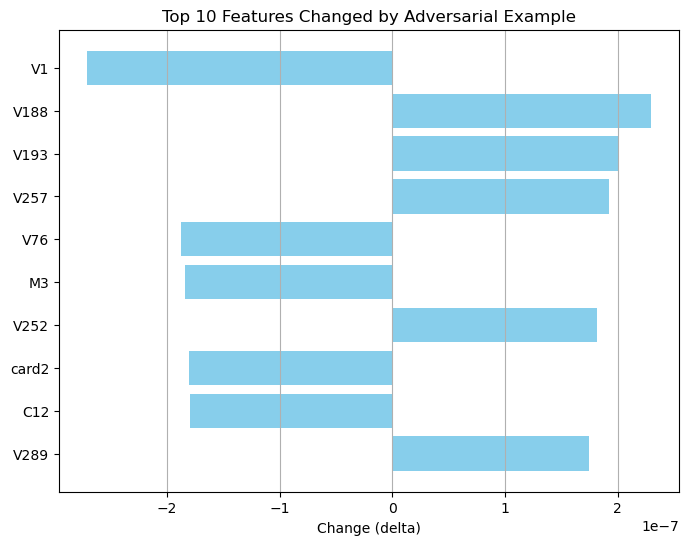

In [48]:
# Take top 10 features by absolute change
top_changes = df_changes.head(10).sort_values('abs_delta', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top_changes['feature'], top_changes['delta'], color='skyblue')
plt.xlabel('Change (delta)')
plt.title('Top 10 Features Changed by Adversarial Example')
plt.grid(axis='x')
plt.show()